In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=50,resize=0.4)
#选取样本量量更多的那些人脸，这样会方便训练
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
lfw_data = pd.DataFrame( lfw_people.data)	
lfw_data['species'] = lfw_people.target_names[lfw_people.target]	
lfw_data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1841,1842,1843,1844,1845,1846,1847,1848,1849,species
0,0.317647,0.355556,0.452288,0.401307,0.349020,0.467974,0.487582,0.508497,0.573856,0.606536,...,0.385621,0.481046,0.450980,0.448366,0.398693,0.350327,0.422222,0.592157,0.490196,Tony Blair
1,0.138562,0.274510,0.334641,0.359477,0.384314,0.363399,0.360784,0.350327,0.345098,0.349020,...,0.154248,0.206536,0.198693,0.189542,0.245752,0.247059,0.233987,0.326797,0.453595,Gerhard Schroeder
2,0.335948,0.218301,0.227451,0.261438,0.281046,0.303268,0.300654,0.300654,0.366013,0.437909,...,0.583007,0.640523,0.666667,0.678431,0.694118,0.712418,0.695425,0.320261,0.303268,Donald Rumsfeld


In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1560
n_features: 1850
n_classes: 12


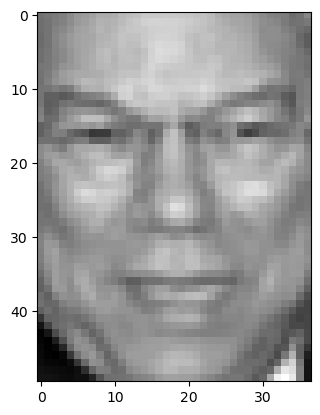

In [6]:
plt.imshow(lfw_people.images[5],cmap='gray')
plt.show()

In [7]:
x_train,x_test,y_train,y_test = train_test_split(lfw_people.data,lfw_people.target)#默认比例25%用于做测试集
x_train.shape

(1170, 1850)

# Preprocessing:


由于lfw数据集本身已经做了一些数据处理，比如每张图片的尺寸为250X250（shape统一），同时我们调用的数据集也做了灰度化处理来降低复杂度。因此数据预处理上可以做的事情就比较简单，我们可以比较两种数据预处理方法：标准化和归一化。（**可以分别在SVM、CNN上把两种预处理的数据都跑一遍看看结果符不符合预期**）

***标准化*** 

$$X=\frac{X-\mu}{\sigma}$$

作用：使数据均值为 0，方差为 1，适合基于距离的算法（如 SVM、KNN、PCA）。

但代码结果显示mean $\neq$ 0, $std \neq 1$,原因是PCA、SVM等机器学习模型都遵循scikit-learn 的约定，输入数据 X 必须是形状为 (n_samples, n_features) 的 二维数组，*每一行*是一个样本，*每一列*是一个特征值（如人脸图像的一个像素、一个颜色通道等），而实际代码计算的时候是根据特征值进行标准化（按列），即对于每个元素 $X_{ij}$:
$$ X_{ij}=\frac{X_{ij}-\mu_{j}}{\sigma_{j}} $$
而这里的mean和std都是按行（也就是对于一张图片而言）的，所以会存在mean不等于0等现象。

*标准化的特点*:标准化计算中

$$\mu = \frac{1}{n}\sum_{i=1}^n X, \quad \sigma = \sqrt{\frac{1}{n}\sum_{i=1}^n (X-\mu)^2} $$

经过标准化后，对于标准差 $\sigma$ 较大的特征值，由于标准差计算中 $\sigma$ 在分母，会实际缩小这些值的差异，让不同图片中区分度很大的地方（可能是噪声）变平滑；同时，对于标准差 $\sigma$ 较小的特征值，标准差计算会放大这些值的特点，也就是对于图像中相同的或者相似的部分，标准化会增强这一特征（比如图片亮处更亮、暗处更暗）。所以整体上，标准化可以使同一特征值的数据更加一致，数据间的距离和差值更小，因此适合基于距离的算法（如 SVM、KNN、PCA）。

***归一化*** 

$$X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

作用：将数据线性压缩到固定范围（默认 [0, 1]），适合需要限定输入范围的模型（如神经网络）。

*归一化的特点*：归一化计算中实际上也是对特征进行计算：
$$X_{norm}[:,j] = \frac{X[:,j]-minX[:,j]}{maxX[:,j]-minX[:,j]}$$
这本质上是一种线性变换，数据的分布形状不会产生变化，仅仅是进行缩放和平移（仿射变换），也解释了跑出来的图相较和原图差异不大的现象。
$$X_{norm}=aX+b,\quad a=\frac{1}{X_{max}-X_{min}},\quad b=\frac{-X_{min}}{X_{max}-X_{min}} $$

和Batch Normalization一样，缓解梯度消失/爆炸问题，适用于CNN


=== Sample 881 (Person: Junichiro Koizumi) ===


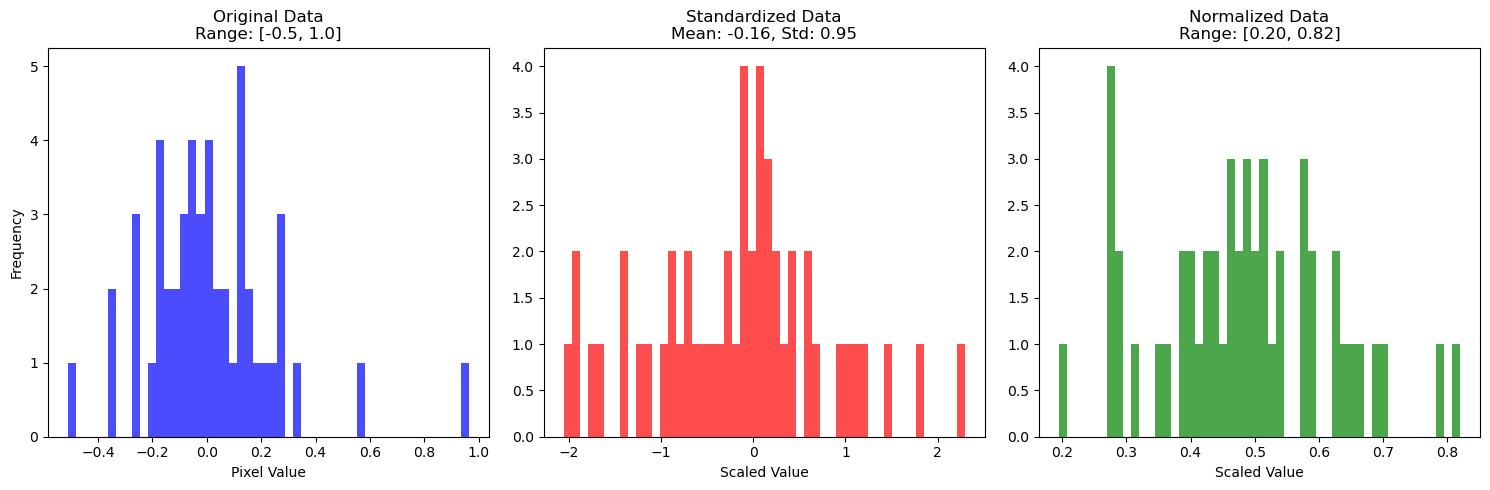

ValueError: cannot reshape array of size 50 into shape (50,37)

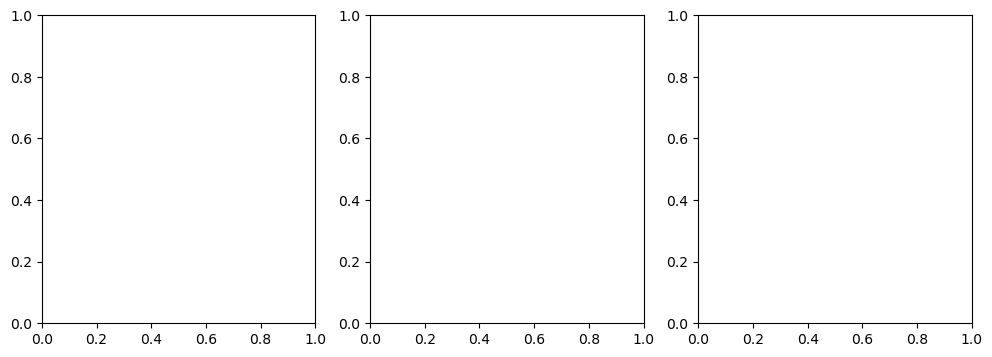

In [26]:
# 2. 预处理
# 标准化
scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)
# 归一化
scaler_norm = MinMaxScaler()
X_norm = scaler_norm.fit_transform(X)

# 3. 可视化分布
def plot_distribution(X_original, X_std, X_norm, sample_idx=0):
    """绘制三种处理方式的分布对比"""
    plt.figure(figsize=(15, 5))
    
    # 原始数据
    plt.subplot(1, 3, 1)
    plt.hist(X_original[sample_idx], bins=50, color='blue', alpha=0.7)
    plt.title(f"Original Data\nRange: [{X_original[sample_idx].min():.1f}, {X_original[sample_idx].max():.1f}]")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    
    # 标准化后
    plt.subplot(1, 3, 2)
    plt.hist(X_std[sample_idx], bins=50, color='red', alpha=0.7)
    plt.title(f"Standardized Data\nMean: {X_std[sample_idx].mean():.2f}, Std: {X_std[sample_idx].std():.2f}")
    plt.xlabel("Scaled Value")
    
    # 归一化后
    plt.subplot(1, 3, 3)
    plt.hist(X_norm[sample_idx], bins=50, color='green', alpha=0.7)
    plt.title(f"Normalized Data\nRange: [{X_norm[sample_idx].min():.2f}, {X_norm[sample_idx].max():.2f}]")
    plt.xlabel("Scaled Value")
    
    plt.tight_layout()
    plt.show()

# 4. 随机选择5个人脸样本对比
for i in np.random.choice(len(X), 5, replace=False):
    print(f"\n=== Sample {i} (Person: {lfw_people.target_names[lfw_people.target[i]]}) ===")
    plot_distribution(X, X_std, X_norm, sample_idx=i)
    
    # 可视化图像对比
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X[i].reshape(h, w), cmap='gray')
    axes[0].set_title("Original Image")
    axes[1].imshow(X_std[i].reshape(h, w), cmap='gray')
    axes[1].set_title("Standardized Image")
    axes[2].imshow(X_norm[i].reshape(h, w), cmap='gray')
    axes[2].set_title("Normalized Image")
    plt.show()

In [ ]:
#标准化操作
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Using SVC only

In [ ]:
model = SVC(kernel='rbf',class_weight='balanced')
#rbf核能拟合高度非线性的数据能应用于图像分类
#balance作用：如果不同类别各自的样本数量差距比较大，
#这时候构建的模型容易把所有的数据归类给样本量大的类别（这时候error rate反而会小）
#解决方法是取出等量的样本个数
#在分类的时候把样本多的权重小一点


model.fit(x_train,y_train)

SVC(class_weight='balanced')

In [ ]:
predictions=model.predict(x_test)
print(classification_report(y_test, predictions, target_names=lfw_people.target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.67      0.74        21
     Colin Powell       0.77      0.89      0.82        61
  Donald Rumsfeld       0.71      0.81      0.76        27
    George W Bush       0.88      0.86      0.87       132
Gerhard Schroeder       0.64      0.70      0.67        23
      Hugo Chavez       0.85      0.65      0.73        17
   Jacques Chirac       0.89      0.80      0.84        10
    Jean Chretien       0.89      0.57      0.70        14
    John Ashcroft       0.62      0.83      0.71        12
Junichiro Koizumi       1.00      0.88      0.94        17
  Serena Williams       0.81      0.81      0.81        16
       Tony Blair       0.72      0.72      0.72        40

         accuracy                           0.80       390
        macro avg       0.80      0.77      0.78       390
     weighted avg       0.81      0.80      0.80       390



# PCA降维度

In [12]:

from sklearn.preprocessing import StandardScaler

n_components=50
pca=PCA(n_components=n_components,whiten=True).fit(x_train)
x_all_pca=pca.transform(lfw_people.data)
x_train_pca=pca.transform(x_train)
x_test_pca=pca.transform(x_test)
eigenfaces = pca.components_.reshape((n_components, h, w))

In [13]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

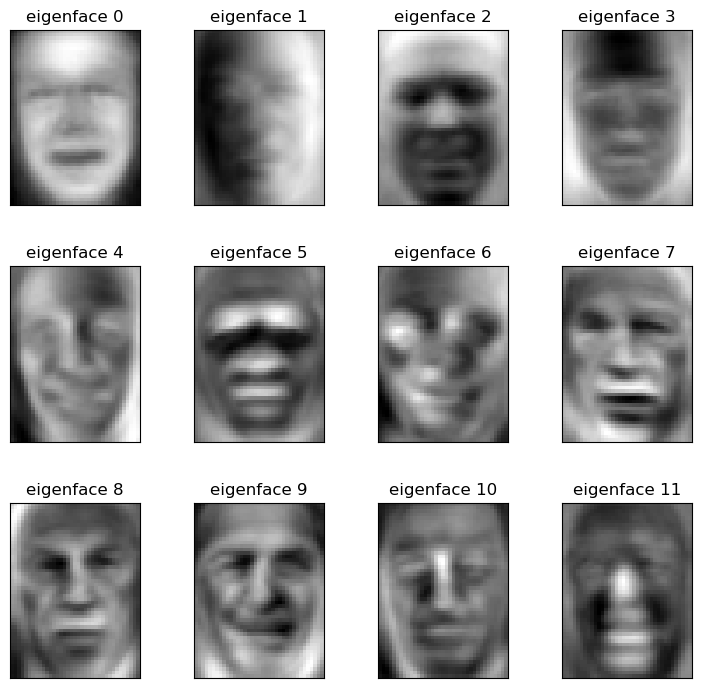

In [14]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [15]:
x_train_pca.shape

(1170, 50)

In [16]:
model = SVC(kernel='rbf',class_weight='balanced')#如果不同类别各自的样本数量差距比较大，
#这时候构建的模型容易把所有的数据归类给样本量大的类别（这时候error rate反而会小）
#解决方法是取出等量的样本个数
#在分类的时候把样本多的权重小一点

model.fit(x_train_pca,y_train)

SVC(class_weight='balanced')

In [17]:
predictions=model.predict(x_test_pca)
print(classification_report(y_test, predictions, target_names=lfw_people.target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.76      0.84        21
     Colin Powell       0.89      0.92      0.90        61
  Donald Rumsfeld       0.66      0.85      0.74        27
    George W Bush       0.84      0.87      0.86       132
Gerhard Schroeder       0.62      0.70      0.65        23
      Hugo Chavez       1.00      0.71      0.83        17
   Jacques Chirac       0.62      0.50      0.56        10
    Jean Chretien       0.90      0.64      0.75        14
    John Ashcroft       0.69      0.92      0.79        12
Junichiro Koizumi       1.00      0.88      0.94        17
  Serena Williams       1.00      0.69      0.81        16
       Tony Blair       0.78      0.78      0.78        40

         accuracy                           0.82       390
        macro avg       0.83      0.77      0.79       390
     weighted avg       0.83      0.82      0.82       390



In [18]:
param_grid={'C':[0.1,1,5,10,100],
           'gamma':[0.0005,0.001,0.005,0.01],}
#C是正则化参用于损失函数

#gamma 大（如 gamma=10）：核函数衰减快，模型更关注邻近样本，易过拟合（复杂边界）。
#gamma 小（如 gamma=0.01）：核函数衰减慢，决策边界平滑，易欠拟合。
"""SVM 的原始目标是找到一个最优超平面（决策边界）来最大化分类间隔。但现实中的数据往往是非线性可分的，这时就需要核函数：

线性 SVM：

直接用超平面 
wT x+b=0 分类，适用于线性可分数据。

优化目标是最小化∣∣w∣|^2（间隔最大化）。

非线性 SVM：

通过核函数将数据映射到高维空间，在高维空间中用超平面分类。

"""
model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(x_train_pca,y_train)
print(model.best_estimator_)


SVC(C=10, class_weight='balanced', gamma=0.01)


In [19]:
predictions=model.predict(x_test_pca)
print(classification_report(y_test,predictions,target_names=lfw_people.target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.84      0.76      0.80        21
     Colin Powell       0.82      0.95      0.88        61
  Donald Rumsfeld       0.63      0.81      0.71        27
    George W Bush       0.90      0.91      0.90       132
Gerhard Schroeder       0.70      0.83      0.76        23
      Hugo Chavez       1.00      0.59      0.74        17
   Jacques Chirac       0.71      0.50      0.59        10
    Jean Chretien       0.83      0.71      0.77        14
    John Ashcroft       0.69      0.75      0.72        12
Junichiro Koizumi       1.00      0.88      0.94        17
  Serena Williams       1.00      0.75      0.86        16
       Tony Blair       0.86      0.75      0.80        40

         accuracy                           0.84       390
        macro avg       0.83      0.77      0.79       390
     weighted avg       0.85      0.84      0.84       390



In [20]:
param_grid={'C':[3,4,5,6,7],
           'gamma':[0.003,0.004, 0.005, 0.006,0.007]}
model=GridSearchCV(SVC(kernel='rbf',class_weight='balanced'),param_grid)
#传入param_grid之后会使用所有C和gamma参数的组合
model.fit(x_train_pca,y_train)
print(model.best_estimator_)

SVC(C=3, class_weight='balanced', gamma=0.007)


In [21]:
predictions=model.predict(x_test_pca)
print(classification_report(y_test,predictions,target_names=lfw_people.target_names))


                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.76      0.84        21
     Colin Powell       0.79      0.92      0.85        61
  Donald Rumsfeld       0.62      0.89      0.73        27
    George W Bush       0.93      0.81      0.87       132
Gerhard Schroeder       0.55      0.74      0.63        23
      Hugo Chavez       0.79      0.65      0.71        17
   Jacques Chirac       0.58      0.70      0.64        10
    Jean Chretien       0.77      0.71      0.74        14
    John Ashcroft       0.62      0.83      0.71        12
Junichiro Koizumi       1.00      0.88      0.94        17
  Serena Williams       1.00      0.75      0.86        16
       Tony Blair       0.86      0.75      0.80        40

         accuracy                           0.81       390
        macro avg       0.79      0.78      0.78       390
     weighted avg       0.83      0.81      0.81       390



In [22]:

X=np.array(x_all_pca)
y=np.array(lfw_people.target)

## With Cross-Validation

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate_with_accuracy(X, y, model, n_splits=5):
    """
    实现交叉验证并在每个fold输出准确率
    
    参数:
    - X: 特征数据
    - y: 标签数据
    - model: SVC
    - n_splits: 交叉验证的折数
    
    返回:
    - 平均准确率
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        scaler = StandardScaler()
        X_train, X_test = X[train_idx], X[test_idx]
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        print(f"Fold {fold}: Accuracy = {accuracy:.4f}")
    
    avg_accuracy = np.mean(accuracies)
    print(f"\nAverage Accuracy: {avg_accuracy:.4f}")
    return avg_accuracy

# 示例调用
model = SVC(kernel='rbf', class_weight='balanced', C=7, gamma=0.007)  # 使用之前调参的最佳参数

cross_validate_with_accuracy(X, y, model, n_splits=10)

Fold 1: Accuracy = 0.8077
Fold 2: Accuracy = 0.8269
Fold 3: Accuracy = 0.8013
Fold 4: Accuracy = 0.8013
Fold 5: Accuracy = 0.8462
Fold 6: Accuracy = 0.7821
Fold 7: Accuracy = 0.8397
Fold 8: Accuracy = 0.8077
Fold 9: Accuracy = 0.8077
Fold 10: Accuracy = 0.8269

Average Accuracy: 0.8147


0.8147435897435897

In [24]:
predictions=model.predict(x_test_pca)
print(classification_report(y_test,predictions,target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      1.00      1.00        21
     Colin Powell       0.97      0.98      0.98        61
  Donald Rumsfeld       0.87      0.96      0.91        27
    George W Bush       0.97      0.95      0.96       132
Gerhard Schroeder       0.96      1.00      0.98        23
      Hugo Chavez       1.00      1.00      1.00        17
   Jacques Chirac       1.00      1.00      1.00        10
    Jean Chretien       1.00      1.00      1.00        14
    John Ashcroft       1.00      1.00      1.00        12
Junichiro Koizumi       1.00      1.00      1.00        17
  Serena Williams       1.00      0.94      0.97        16
       Tony Blair       0.97      0.95      0.96        40

         accuracy                           0.97       390
        macro avg       0.98      0.98      0.98       390
     weighted avg       0.97      0.97      0.97       390



# 画图

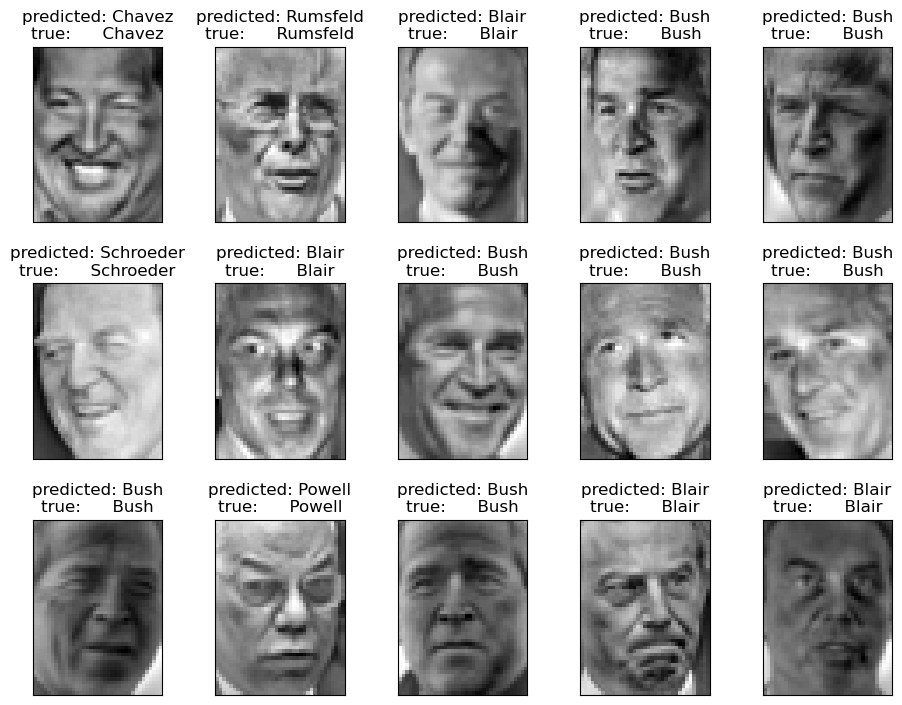

In [25]:
def plot_gallery(images, titles, h, w, n_rows=3, n_cols=5):
    plt.figure(figsize=(1.8 * n_cols, 2.4 * n_rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)  # 修正：n_rows 和 i+1（整数索引）
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(prediction, true_label, target_names):
    pred_name = target_names[prediction].split(' ')[-1]
    true_name = target_names[true_label].split(' ')[-1]
    return f'predicted: {pred_name}\ntrue:      {true_name}'

# 修正：传入 predictions[i] 和 y_test[i] 作为参数
prediction_titles = [title(predictions[i], y_test[i], target_names) for i in range(len(predictions))]
plot_gallery(x_test, prediction_titles, h, w)
plt.show()